<a href="https://colab.research.google.com/github/kevintsi/deep_learning_course/blob/main/project_dl_covid_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Projet Deep Learning : Détection de COVID

In [11]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [12]:
from fastbook import *
from fastai.vision.widgets import *

In [13]:
Ntrain = 400
Nval = 200

covid_sample_path = f"gdrive/MyDrive/covid_detection_sample_{Ntrain}_Ntrain_{Nval}_Nval"

In [14]:
state_types = ["COVID", "Normal", "Opacite_Pulmonaire", "Pneumonie_Virale"] 

In [15]:
fns = get_image_files(covid_sample_path+"/train")
fns

(#400) [Path('gdrive/MyDrive/covid_detection_sample_400_Ntrain_200_Nval/train/COVID/COVID-1.png'),Path('gdrive/MyDrive/covid_detection_sample_400_Ntrain_200_Nval/train/COVID/COVID-15.png'),Path('gdrive/MyDrive/covid_detection_sample_400_Ntrain_200_Nval/train/COVID/COVID-4.png'),Path('gdrive/MyDrive/covid_detection_sample_400_Ntrain_200_Nval/train/COVID/COVID-5.png'),Path('gdrive/MyDrive/covid_detection_sample_400_Ntrain_200_Nval/train/COVID/COVID-2.png'),Path('gdrive/MyDrive/covid_detection_sample_400_Ntrain_200_Nval/train/COVID/COVID-13.png'),Path('gdrive/MyDrive/covid_detection_sample_400_Ntrain_200_Nval/train/COVID/COVID-8.png'),Path('gdrive/MyDrive/covid_detection_sample_400_Ntrain_200_Nval/train/COVID/COVID-9.png'),Path('gdrive/MyDrive/covid_detection_sample_400_Ntrain_200_Nval/train/COVID/COVID-16.png'),Path('gdrive/MyDrive/covid_detection_sample_400_Ntrain_200_Nval/train/COVID/COVID-14.png')...]

In [16]:
failed = verify_images(fns)
failed

(#0) []

In [17]:
failed.map(Path.unlink);

In [72]:
states = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label)

In [73]:
dls = states.dataloaders(covid_sample_path)

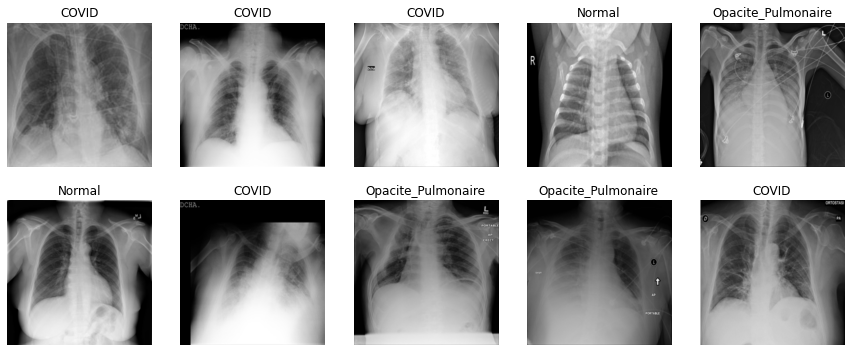

In [74]:
dls.valid.show_batch(max_n=10, nrows=2)

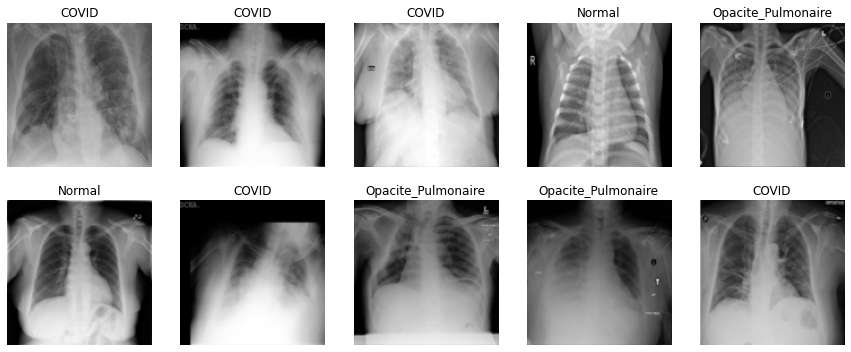

In [76]:
states = states.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = states.dataloaders(covid_sample_path)
dls.valid.show_batch(max_n=10, nrows=2)

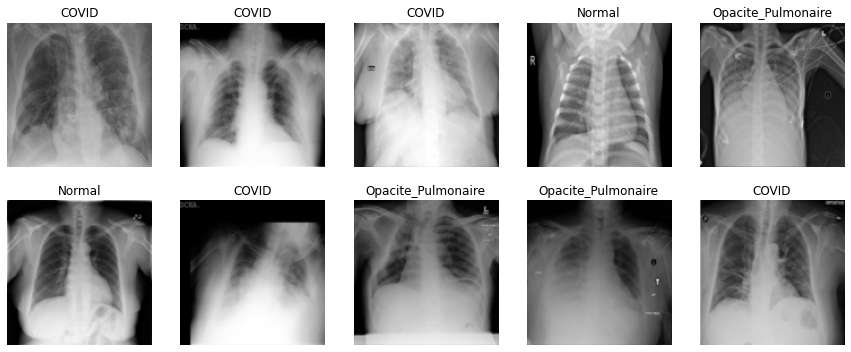

In [78]:
states = states.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode="zeros"))
dls = states.dataloaders(covid_sample_path)
dls.valid.show_batch(max_n=10, nrows=2)

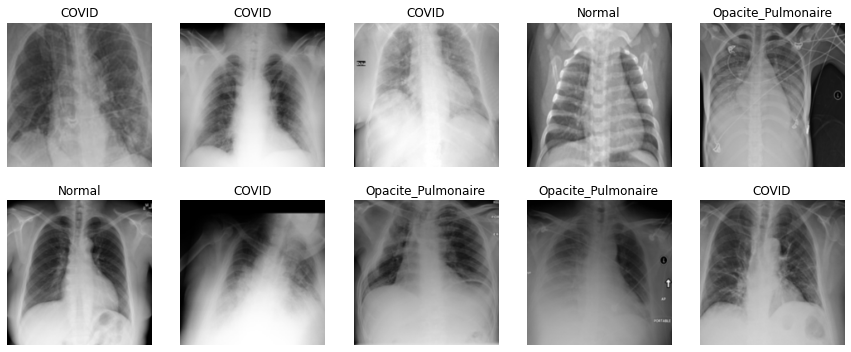

In [79]:
states = states.new(item_tfms=RandomResizedCrop(175, min_scale=0.3))
dls = states.dataloaders(covid_sample_path)
dls.valid.show_batch(max_n=10, nrows=2)

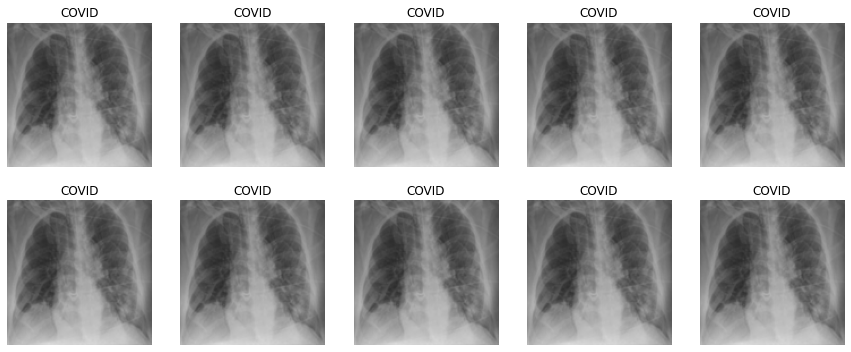

In [80]:
states = states.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = states.dataloaders(covid_sample_path)
dls.valid.show_batch(max_n=10, nrows=2, unique=True)

In [81]:
states = states.new(item_tfms=RandomResizedCrop(275, min_scale=0.6), batch_tfms=aug_transforms())
dls = states.dataloaders(covid_sample_path)

In [82]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(10)

epoch,train_loss,valid_loss,error_rate,time
0,1.849421,1.449982,0.422222,00:06


epoch,train_loss,valid_loss,error_rate,time
0,0.918780,1.077881,0.366667,00:07
1,0.834399,0.849597,0.250000,00:07
2,0.755005,0.712243,0.233333,00:07
3,0.684446,0.648811,0.194444,00:07
4,0.621938,0.588684,0.166667,00:07
5,0.560012,0.418259,0.133333,00:07
6,0.513294,0.440620,0.138889,00:07
7,0.465769,0.428603,0.122222,00:07
8,0.424314,0.407899,0.122222,00:07
9,0.380709,0.407907,0.116667,00:07


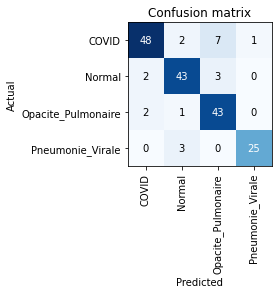

In [84]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

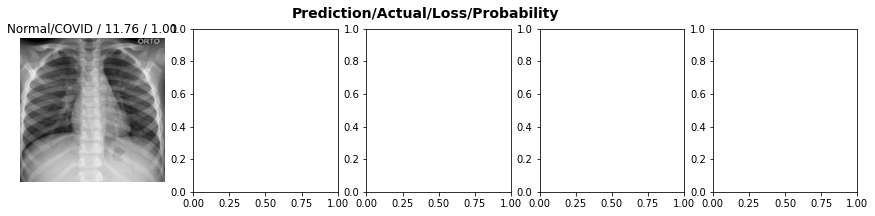

In [85]:
interp.plot_top_losses(5, nrows=1)

In [86]:
cleaner = ImageClassifierCleaner(learn)
cleaner

In [30]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()

In [31]:
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

In [87]:
learn.export()

In [88]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [89]:
learn_inf = load_learner(path/'export.pkl')

In [90]:
learn_inf.dls.vocab

['COVID', 'Normal', 'Opacite_Pulmonaire', 'Pneumonie_Virale']

In [106]:
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [107]:
img = PILImage.create(btn_upload.data[-1])

In [108]:
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

Output()

In [109]:
pred,pred_idx,probs = learn_inf.predict(img)

In [110]:
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction: Opacite_Pulmonaire; Probability: 0.7596')